In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline
import typing
import scipy

In [2]:
def same(*args):
    for arg in args:
        assert args[0] == arg
    return args[0]

In [3]:
def chebyshev_1(n):
    return np.sort(np.cos((np.arange(n)*2 + 1) / (2*n) * np.pi))

In [4]:
def chebyshev_2(n):
    return np.sort(np.cos(np.arange(n) / (n-1) * np.pi))

# 1

In [5]:
def lagrange_polys(
    points,
    nodes,
):
    n = len(nodes)
    
    xk = np.repeat(nodes.reshape(-1, 1), n-1, 1)
    xj = np.repeat(nodes.reshape(1, -1), n, 0)[~np.eye(n, dtype=bool)].reshape(n, -1)
    ls = []
    for x in points:
        lx = np.prod(x - xj, 1) / np.prod(xk - xj, 1)
        ls.append(lx)
    ls = np.array(ls)
    ls = ls.T
    return ls


def lagrange_inter(
    points,
    nodes,
    values,
):
    same(1, len(nodes.shape), len(values.shape))
    same(len(nodes), len(values))

    output = np.zeros_like(points)

    polys = lagrange_polys(points, nodes)
    polys = polys.T

    for i, poly in enumerate(polys):
        output[i] = np.sum(poly * values)
    return output

In [6]:
class Polynomial:
    def __init__(self, coeff):
        if isinstance(coeff, list):
            coeff = np.array(coeff)
        
        same(1, len(coeff.shape))
        i = len(coeff)-1
        while i >= 0 and coeff[i] == 0:
            i -= 1
        coeff = coeff[:i+1]
        self.coeff = coeff

    def diff(self):
        coeff = self.coeff[1:]
        coeff *= np.arange(0, len(coeff))+1
        return Polynomial(coeff)

    def len(self):
        return len(self.coeff)
    
    def __add__(self, other):
        len_ = max(self.len(), other.len())
        coeff = np.zeros(len_)
        coeff[:self.len()] += self.coeff
        coeff[:other.len()] += other.coeff
        return Polynomial(coeff)
    
    def __mul__(self, other):
        len_ = self.len() + other.len() - 1
        coeff = np.zeros(len_)
        for i, sc in enumerate(self.coeff):
            for j, oc in enumerate(other.coeff):
                coeff[i+j] += sc*oc
        return Polynomial(coeff)
    
    def eval(self, x):
        x = np.reshape(x, (-1, 1))
        return np.sum(x**np.arange(self.len()) * self.coeff, 1)

In [7]:
def hermite_poly(
    nodes,
    values,
    values_d,
) -> Polynomial:
    same(1, len(nodes.shape), len(values.shape), len(values_d.shape))
    m = same(nodes.shape[0], values.shape[0], values_d.shape[0])
    
    z = np.repeat(nodes, 2)
    Q = np.zeros((2*m, 2*m))
    Q[:, 0] = np.repeat(values, 2)
    Q[np.arange(m)*2+1, 1] = values_d

    r = np.arange(1, m)
    Q[(r-1)*2+2, 1] = (Q[r*2, 0] - Q[r*2 - 1, 0]) / (z[r*2] - z[r*2 - 1])

    for i in range(2, 2*m):
        for j in range(2, i+1):
            Q[i, j] = (Q[i, j-1] - Q[i-1, j-1]) / (z[i] - z[i-j])

    d = np.diag(Q)
    poly_acc = Polynomial([1])
    poly = Polynomial([])
    for i in range(2*m):
        poly = poly + poly_acc * Polynomial([d[i]])
        poly_acc = poly_acc * Polynomial([-z[i], 1])
    return poly

## (a)

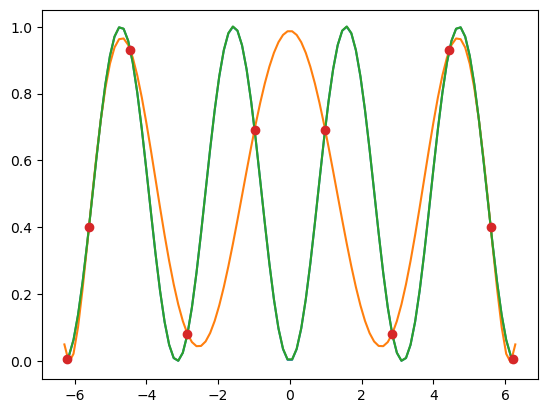

In [8]:
def f(x):
    return np.sin(x)**2

def fd(x):
    return 2*np.sin(x)*np.cos(x)

nodes = chebyshev_1(10)*2*np.pi
points = np.linspace(-2*np.pi, 2*np.pi, 100)

plt.plot(points, f(points))

plt.plot(
    points,
    lagrange_inter(
        points,
        nodes,
        f(nodes),
    )
)

p = hermite_poly(nodes, f(nodes), fd(nodes))
plt.plot(points, p.eval(points))

plt.plot(nodes, f(nodes), "o")

## (b)

In [9]:
t = np.pi/5

v = np.sin(t)**2
v_lagrange = lagrange_inter(np.array([t]), nodes, f(nodes))[0]
p = hermite_poly(nodes, f(nodes), fd(nodes))
v_hermite = p.eval(t)[0]

print(v)
print(v_lagrange)
print(v_hermite)

0.3454915028125263
0.8587267870604571
0.34586437790527536


## (c)

### eroarea practica

In [10]:
print("lagrange", np.abs(v-v_lagrange))
print("hermite", np.abs(v-v_hermite))

lagrange 0.5132352842479309
hermite 0.00037287509274908093


In [11]:
len(nodes)

10

### eroarea teoretica

apare la final...

# 2

In [12]:
def s(xj, x):
    return np.array([1, (x-xj), (x-xj)**2, (x-xj)**3])


def sd(xj, x):
    return np.array([0, 1, 2*(x-xj), 3*(x-xj)**2])


def sdd(xj, x):
    return np.array([0, 0, 2, 6*(x-xj)])


def sddd(xj, x):
    return np.array([0, 0, 0, 6])


class Spline:
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        yd: np.ndarray,
        ydd: np.ndarray,
        *,
        kind: typing.Literal["clamped", "natural_1", "natural_2", "deboor"],
    ):
        assert kind in {"clamped", "natural_1", "natural_2", "deboor"}
        same(1, len(x.shape), len(y.shape), len(yd.shape), len(ydd.shape))
        n = same(len(x), len(y), len(yd), len(ydd))

        polys_no = n-1
        eqs_no = polys_no*4
        A = scipy.sparse.dok_array((eqs_no, eqs_no))
        b = np.zeros(eqs_no)

        eqs_iter = iter(range(eqs_no))

        match kind:
            case "natural_1":
                eqi = next(eqs_iter)
                A[eqi, 0*4:(0+1)*4] = sd(x[0], x[0])
                b[eqi] = 0
                
                eqi = next(eqs_iter)
                A[eqi, (polys_no-1)*4:(polys_no-1+1)*4] = sd(x[polys_no-1], x[polys_no])
                b[eqi] = 0
            case "natural_2":
                eqi = next(eqs_iter)
                A[eqi, 0*4:(0+1)*4] = sdd(x[0], x[0])
                b[eqi] = 0
                
                eqi = next(eqs_iter)
                A[eqi, (polys_no-1)*4:(polys_no-1+1)*4] = sdd(x[polys_no-1], x[polys_no])
                b[eqi] = 0
            case "clamped":
                eqi = next(eqs_iter)
                A[eqi, 0*4:(0+1)*4] = sd(x[0], x[0])
                b[eqi] = yd[0]
                
                eqi = next(eqs_iter)
                A[eqi, (polys_no-1)*4:(polys_no-1+1)*4] = sd(x[polys_no-1], x[polys_no])
                b[eqi] = yd[polys_no]
            case "deboor":
                eqi = next(eqs_iter)
                A[eqi, 0*4:(0+2)*4] = np.concatenate(
                    (sddd(x[0], x[0]), -sddd(x[1], x[0]))
                )
                b[eqi] = 0
                
                eqi = next(eqs_iter)
                A[eqi, (polys_no-2)*4:(polys_no-2+2)*4] = np.concatenate(
                    (sddd(x[polys_no-2], x[polys_no]), -sddd(x[polys_no-1], x[polys_no]))
                )
                b[eqi] = 0
        
        for i in range(polys_no):
            eqi = next(eqs_iter)
            A[eqi, i*4:(i+1)*4] = s(x[i], x[i])
            b[eqi] = y[i]

            eqi = next(eqs_iter)
            A[eqi, i*4:(i+1)*4] = s(x[i], x[i+1])
            b[eqi] = y[i+1]

        for i in range(polys_no-1):
            eqi = next(eqs_iter)
            A[eqi, i*4:(i+2)*4] = np.concatenate((sd(x[i], x[i+1]), -sd(x[i+1], x[i+1])))
            b[eqi] = 0
            
            eqi = next(eqs_iter)
            A[eqi, i*4:(i+2)*4] = np.concatenate((sdd(x[i], x[i+1]), -sdd(x[i+1], x[i+1])))
            b[eqi] = 0

        A = A.tocsr()
        coef = scipy.sparse.linalg.spsolve(A, b)
        coef = coef.reshape(-1, 4)
        
        self.polys_no = polys_no
        self.nodes = x.copy()
        self.coef = coef

    def eval(self, x):
        poly_i = np.searchsorted(self.nodes, x)-1
        poly_i = np.clip(poly_i, 0, self.polys_no-1)

        xj = self.nodes[poly_i]
        coef = self.coef[poly_i]

        res = np.sum(
            (
                (x - xj).reshape(-1, 1) ** np.arange(4)
                *
                coef
            ),
            axis=1,
        )
        return res

In [13]:
def least_squares(
    A: np.ndarray,
    b: np.ndarray,
):
    Ap = np.matmul(A.T, A)
    bp = np.matmul(A.T, b)
    return np.linalg.solve(Ap, bp)

## (a)

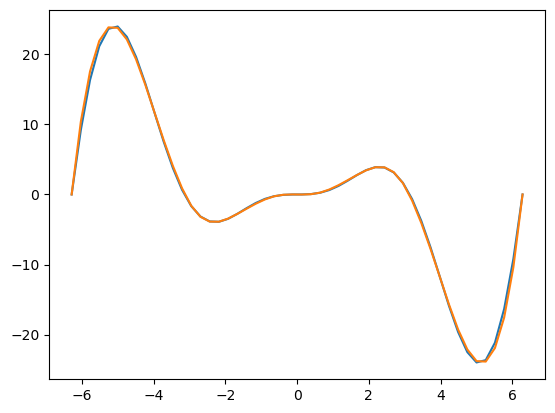

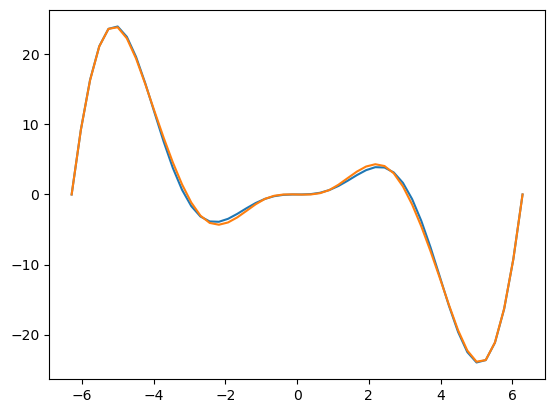

In [14]:
def f(x):
    return x**2*np.sin(x)

def fd(x):
    return 2*x*np.sin(x) + x**2*np.cos(x)

def fdd(x):
    return 2*np.sin(x) + 2*np.cos(x) + 2*x*np.cos(x) - x**2*np.sin(x)

points = np.linspace(-2*np.pi, 2*np.pi)

plt.figure()
plt.plot(points, f(points))
nodes = np.linspace(-2*np.pi, 2*np.pi, 12)
sp = Spline(nodes, f(nodes), fd(nodes), fdd(nodes), kind="deboor")
plt.plot(points, sp.eval(points))

plt.figure()
plt.plot(points, f(points))
nodes = chebyshev_2(12)*2*np.pi
sp = Spline(nodes, f(nodes), fd(nodes), fdd(nodes), kind="deboor")
plt.plot(points, sp.eval(points))

## (b)

Aproximam cu baza polinomiala.
$$
\sum_{k=0}^{n-1}a_kx^k=y
$$

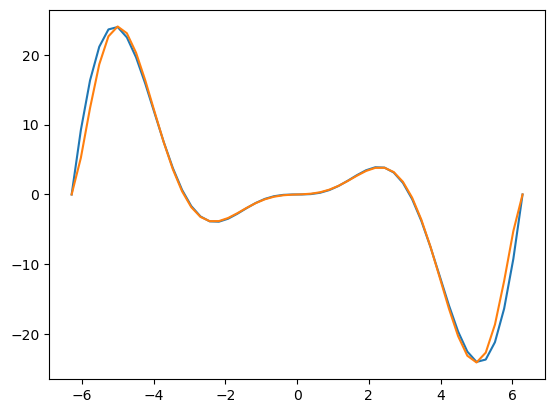

In [15]:
points = np.linspace(-2*np.pi, 2*np.pi)
nodes = np.linspace(-2*np.pi, 2*np.pi, 11)

n = 10

plt.figure()
plt.plot(points, f(points))
A = np.repeat(nodes.reshape(-1, 1), n, 1) ** np.arange(n)
b = f(nodes)
coeff = least_squares(A, b)
plt.plot(
    points,
    np.sum(np.repeat(points.reshape(-1, 1), n, 1) ** np.arange(n) * coeff, 1),
)